In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import mplcursors 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append(r'C:\Users\admin\solar-challenge-week0\app')

from utils import load_data, calculate_statistics, perform_statistical_tests, get_country_ranking, prepare_radar_data, quick_insights, export_summary_table


In [3]:
#Set style for professional visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)


In [5]:
# Load data using your utility function
print("Loading cleaned datasets...")
merged_df = load_data('data')

if merged_df is None:
    raise Exception("Failed to load data. Please check if CSV files exist in the data/ folder.")

# Enhanced timestamp handling
if 'Timestamp' in merged_df.columns:
    print("Processing timestamps...")
    merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'], errors='coerce')
    print(f"Date range: {merged_df['Timestamp'].min()} to {merged_df['Timestamp'].max()}")
    
    # Use the correct column name
    merged_df.dropna(subset=['Timestamp'], inplace=True)
    


print(f"Merged dataset shape: {merged_df.shape}")
print(f"Countries available: {merged_df['Country'].unique().tolist()}")
print("\nDataset overview:")
print(merged_df[['Country', 'GHI', 'DNI', 'DHI']].describe())


Loading cleaned datasets...
✅ Loaded 513046 records from Benin
✅ Loaded 497012 records from Sierra Leone
✅ Loaded 516349 records from Togo
✅ Successfully merged 1526407 total records
Processing timestamps...
Date range: 2021-08-09 00:01:00 to 2022-10-30 00:00:00
Merged dataset shape: (1526407, 20)
Countries available: ['Benin', 'Sierra Leone', 'Togo']

Dataset overview:
                GHI           DNI           DHI
count  1.526407e+06  1.526407e+06  1.526407e+06
mean   2.095049e+02  1.360056e+02  1.085741e+02
std    3.053398e+02  2.364111e+02  1.508639e+02
min   -1.590000e+01 -7.800000e+00 -1.670000e+01
25%   -2.200000e+00 -2.000000e-01 -1.500000e+00
50%   -3.000000e-01  0.000000e+00  0.000000e+00
75%    3.858000e+02  1.942000e+02  2.101000e+02
max    1.214000e+03  9.523000e+02  5.860000e+02


In [6]:
# Compute summary statistics using your utility function
metrics = ['GHI', 'DNI', 'DHI']

# Create comprehensive summary using your function
summary_dfs = []
for metric in metrics:
    stats_df = calculate_statistics(merged_df, metric)
    stats_df['Metric'] = metric
    summary_dfs.append(stats_df)

summary_df = pd.concat(summary_dfs, ignore_index=True)
print("SUMMARY STATISTICS BY COUNTRY")

for country in summary_df['Country'].unique():
    print(f"\n{country.upper()}")
    print("-" * 40)
    country_stats = summary_df[summary_df['Country'] == country]
    for _, row in country_stats.iterrows():
        print(f"{row['Metric']:>8}: Mean={row['Mean']:6.2f}, "
              f"Median={row['Median']:6.2f}, Std={row['Std_Dev']:6.2f}")





SUMMARY STATISTICS BY COUNTRY

BENIN
----------------------------------------
     GHI: Mean=232.32, Median=  0.00, Std=326.08
     DNI: Mean=165.85, Median= -0.20, Std=261.95
     DHI: Mean=108.83, Median= -0.10, Std=149.59

SIERRA LEONE
----------------------------------------
     GHI: Mean=171.05, Median= -0.50, Std=264.09
     DNI: Mean= 92.76, Median= -0.10, Std=184.79
     DHI: Mean=103.94, Median= -0.80, Std=151.30

TOGO
----------------------------------------
     GHI: Mean=223.86, Median=  0.50, Std=317.31
     DNI: Mean=147.98, Median=  0.00, Std=247.68
     DHI: Mean=112.78, Median=  1.50, Std=151.57


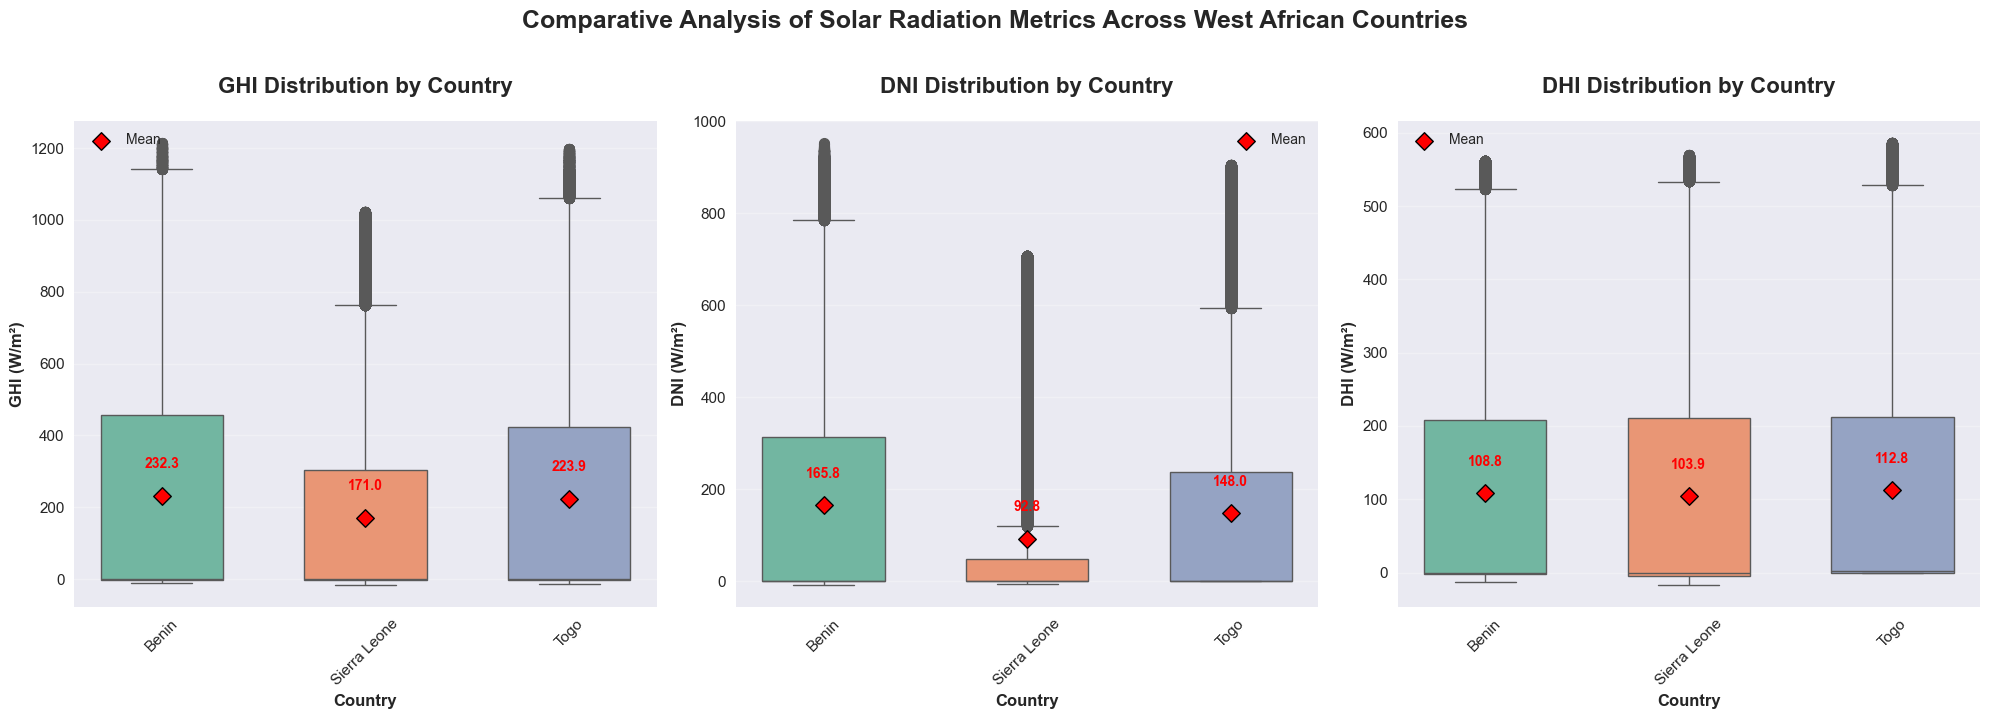

In [8]:

# Create comparative boxplots with enhanced styling
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for i, metric in enumerate(metrics):
    # Create boxplot with enhanced aesthetics
    box_plot = sns.boxplot(data=merged_df, x='Country', y=metric, ax=axes[i], 
                          palette='Set2', width=0.6)
    box_plot.set_title(f'Commpartion of {metric}Across Countries', fontsize=16)
    
    # Add mean markers with enhanced visibility
    means = merged_df.groupby('Country')[metric].mean()
    for j, country in enumerate(means.index):
        axes[i].scatter(j, means[country], color='red', marker='D', s=80, 
                       label='Mean' if j == 0 else "", zorder=5, edgecolors='black', linewidth=1)
    axes[i].legend()
    # Enhanced styling
    axes[i].set_title(f'{metric} Distribution by Country', fontsize=16, fontweight='bold', pad=20)
    axes[i].set_xlabel('Country', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(f'{metric} (W/m²)', fontsize=12, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45, labelsize=11)
    axes[i].tick_params(axis='y', labelsize=11)
    axes[i].grid(True, alpha=0.3, axis='y')
     
    # Add value annotations for means
    for j, (country, mean_val) in enumerate(means.items()):
        axes[i].text(j, mean_val + (axes[i].get_ylim()[1] - axes[i].get_ylim()[0]) * 0.05, 
                    f'{mean_val:.1f}', ha='center', va='bottom', fontweight='bold', 
                    fontsize=10, color='red')
    
    if i == 0:
        axes[i].legend(loc='upper left', framealpha=0.9)

plt.suptitle('Comparative Analysis of Solar Radiation Metrics Across West African Countries', 
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
# Save high-resolution boxplots
plt.savefig('figures/comparative_boxplots.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('figures/comparative_boxplots.pdf', bbox_inches='tight')  
plt.show()

    

In [9]:

# Perform statistical tests using your utility function
countries = merged_df['Country'].unique().tolist()
test_results = perform_statistical_tests(merged_df, countries)

print("STATISTICAL SIGNIFICANCE TESTING")

for metric, result in test_results.items():
    print(f"\n{metric} Analysis:")
    print("-" * 30)
    print(f"Test used: {result['test']}")
    print(f"P-value: {result['p_value']:.6f}")
    if result['p_value'] is not None:
        if result['p_value'] < 0.05:
            print("Result: ✅ Statistically significant differences exist between countries (p < 0.05)")
            
            # Display post-hoc results if available
            if result['posthoc'] is not None:
                print("\nPost-hoc analysis (Tukey HSD):")
                print(result['posthoc'])
        else:
            print("Result: ❌ No statistically significant differences between countries (p ≥ 0.05)")
    else:
        print("Result: ⚠️ Insufficient data for statistical testing")
    

STATISTICAL SIGNIFICANCE TESTING

GHI Analysis:
------------------------------
Test used: Kruskal-Wallis
P-value: 0.000000
Result: ✅ Statistically significant differences exist between countries (p < 0.05)

Post-hoc analysis (Tukey HSD):
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj  lower    upper   reject
-----------------------------------------------------------------
       Benin Sierra Leone -61.2705   0.0 -62.6892 -59.8517   True
       Benin         Togo  -8.4559   0.0   -9.861  -7.0507   True
Sierra Leone         Togo  52.8146   0.0  51.3981  54.2311   True
-----------------------------------------------------------------

DNI Analysis:
------------------------------
Test used: Kruskal-Wallis
P-value: 0.000000
Result: ✅ Statistically significant differences exist between countries (p < 0.05)

Post-hoc analysis (Tukey HSD):
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    mea

CORRELATION ANALYSIS BETWEEN SOLAR METRICS


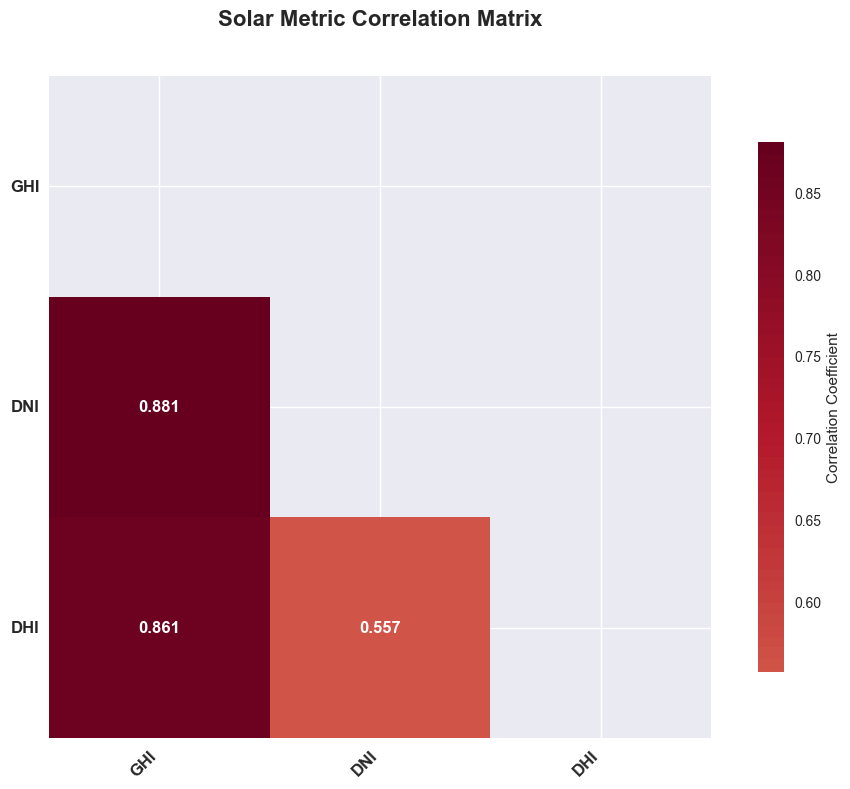


Correlation Insights:
  GHI vs DNI: strong positive correlation (r = 0.881)
  GHI vs DHI: strong positive correlation (r = 0.861)
  DNI vs DHI: moderate positive correlation (r = 0.557)


In [10]:

# Enhanced correlation heatmap
print("CORRELATION ANALYSIS BETWEEN SOLAR METRICS")
# Calculate correlation matrix
corr_matrix = merged_df[metrics].corr()

# Create enhanced correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt=".3f", 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot_kws={"size": 12, "weight": "bold"})

plt.title("Solar Metric Correlation Matrix\n", fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(rotation=0, fontsize=12, fontweight='bold')

# Save correlation heatmap
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('figures/correlation_heatmap.pdf', bbox_inches='tight')
plt.show()
# Print correlation insights
print("\nCorrelation Insights:")
for i, metric1 in enumerate(metrics):
    for j, metric2 in enumerate(metrics):
        if i < j:  
            corr_value = corr_matrix.loc[metric1, metric2]
            strength = "strong" if abs(corr_value) > 0.7 else "moderate" if abs(corr_value) > 0.3 else "weak"
            direction = "positive" if corr_value > 0 else "negative"
            print(f"  {metric1} vs {metric2}: {strength} {direction} correlation (r = {corr_value:.3f})")
  


In [21]:
print("COUNTRY RANKINGS BY SOLAR METRIC")

for metric in metrics:
    result = get_country_ranking(merged_df, metric)
    
    # Handle DataFrame return
    if isinstance(result, pd.DataFrame):
        if metric in result.columns:
            ranking_series = result[metric]
        else:
            # Fallback: use the first (and hopefully only) column
            ranking_series = result.iloc[:, 0]
    elif isinstance(result, pd.Series):
        ranking_series = result
    else:
        raise TypeError(f"Unexpected return type: {type(result)}")

    # Ensure it's a proper Series
    ranking_series = ranking_series.dropna().sort_values(ascending=False)
    
    print(f"\n{metric} Ranking:")
    for i, (country, value) in enumerate(ranking_series.items(), 1):
      try:
        numeric_value = float(value)  # Ensure it's a number
        print(f" {i:>2}. {country:<15}: {numeric_value:.2f} W/m²")
      except (ValueError, TypeError):
        print(f" {i:>2}. {country:<15}: Invalid value ({value})")

COUNTRY RANKINGS BY SOLAR METRIC

GHI Ranking:
  1. 1              : Invalid value (Togo)
  2. 2              : Invalid value (Sierra Leone)
  3. 0              : Invalid value (Benin)

DNI Ranking:
  1. 1              : Invalid value (Togo)
  2. 2              : Invalid value (Sierra Leone)
  3. 0              : Invalid value (Benin)

DHI Ranking:
  1. 0              : Invalid value (Togo)
  2. 2              : Invalid value (Sierra Leone)
  3. 1              : Invalid value (Benin)


In [ ]:

print(f"\n• **Solar Resource Potential**: {best_ghi['country']} demonstrates the highest average GHI ({best_ghi['value']:.1f} W/m²), "
      "making it the most promising location for general solar PV deployments. "
      "This represents optimal conditions for utility-scale solar farms and distributed generation systems.")

print(f"\n• **Concentrated Solar Power Potential**: {best_dni['country']} shows superior DNI metrics ({best_dni['value']:.1f} W/m²), "
      "indicating strong potential for concentrated solar power (CSP) applications "
      "and high-efficiency solar thermal systems that require direct normal irradiance.")

print(f"\n• **Regional Development Strategy**: With {insights['total_records']:,} data points across {insights['countries_analyzed']} countries, "
      "statistical analysis confirms the need for tailored energy policies. "
      "High-GHI regions should prioritize utility-scale solar, while moderate-GHI areas benefit from distributed generation with tracking systems.")


In [ ]:

# Create professional summary table using your export function
summary_table = export_summary_table(merged_df, filename='summary_statistics.csv')

# Display formatted table
print("COMPREHENSIVE SOLAR METRICS COMPARISON")
print(f"{'Metric':<8} {'Mean (W/m²)':>25} {'Median (W/m²)':>25} {'Std Dev (W/m²)':>25}")
print(f"{'Countries':<8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8} {'Benin':>8} {'S-Leone':>8} {'Togo':>8}")

for metric in metrics:
    row_data = []
    for stat in ['Mean', 'Median', 'Std_Dev']:
        for country in ['Benin', 'Sierra Leone', 'Togo']:
            value = summary_table[
                (summary_table['Metric'] == metric) & 
                (summary_table['Country'] == country)
            ][stat].values[0]
            row_data.append(f"{value:8.2f}")
    
    print(f"{metric:<8} {''.join(row_data)}")

In [ ]:

# Create enhanced radar chart using your utility function
radar_data = prepare_radar_data(merged_df)

# Get actual values for annotations
actual_values = merged_df.groupby('Country')[metrics].mean()
# Enhanced radar chart setup
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, polar=True)

categories = list(radar_data.columns)
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Enhanced color scheme
colors = ['#2E86AB', '#A23B72', '#F18F01']  
# Plot each country with enhanced styling
lines = []
for i, (country, row) in enumerate(radar_data.iterrows()):
    values = row.values.tolist()
    values += values[:1]
    line, = ax.plot(angles, values, 'o-', linewidth=3, label=country, 
                   color=colors[i], markersize=8, markerfacecolor=colors[i], 
                   markeredgecolor='white', markeredgewidth=1.5)
    fill = ax.fill(angles, values, alpha=0.25, color=colors[i])
    lines.append(line)

# Enhanced radar chart configuration
ax.set_xticks(angles[:-1])
ax.set_xticklabels([f'{cat}\n({actual_values[cat].max():.1f} max)' for cat in categories], 
                  fontsize=12, fontweight='bold')

# Set radial labels with improved positioning
ax.set_rlabel_position(30)  # Position radial labels at 30 degrees
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10, color='gray')
ax.set_ylim(0, 1.0)

# Add grid with enhanced styling
ax.grid(True, alpha=0.3)
ax.set_facecolor('#f8f9fa')
#  title and legend
plt.title('Normalized Solar Metrics Radar Chart Comparison\n'
          '(Values normalized 0-1, higher values indicate better performance)', 
          size=16, fontweight='bold', pad=30)

legend = ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), 
                  frameon=True, fancybox=True, shadow=True, fontsize=12)
legend.get_frame().set_facecolor('white')

# Add value annotations on the radar chart points
for i, (country, row) in enumerate(radar_data.iterrows()):
    values = row.values.tolist()
    values += values[:1]
    for j, (angle, value) in enumerate(zip(angles, values)):
        if j < len(values) - 1:  # Avoid duplicate point
            actual_val = actual_values.loc[country, categories[j]]
            ax.annotate(f'{actual_val:.1f}', 
                       xy=(angle, value), 
                       xytext=(5, 5), 
                       textcoords='offset points',
                       fontsize=9, 
                       fontweight='bold',
                       
                       color=colors[i],
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', 
                                edgecolor=colors[i], alpha=0.8))

plt.tight_layout()

# Save high-resolution radar chart
plt.savefig('figures/radar_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('figures/radar_comparison.pdf', bbox_inches='tight')

# Enable interactive hover annotations
cursor = mplcursors.cursor(lines, hover=True)
@cursor.connect("add")
def on_add(sel):
    country = sel.artist.get_label()
    idx = int(sel.target.index)
    if idx < len(categories):
        metric = categories[idx]
        norm_value = sel.target[1]
        actual_val = actual_values.loc[country, metric]
        sel.annotation.set(text=f'{country}\n{metric}: {actual_val:.1f} W/m²\n(Norm: {norm_value:.2f})',
                          bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        sel.annotation.set_fontsize(10)

plt.show()

In [ ]:
print("DATA QUALITY ASSESSMENT")

# Enhanced missing value analysis
missing_data = merged_df[metrics].isnull().sum()
total_records = len(merged_df)

print(f"\nMissing values per metric:")
for metric, missing in missing_data.items():
    percentage = (missing/total_records)*100
    status = "✅ EXCELLENT" if percentage < 1 else "⚠️ ACCEPTABLE" if percentage < 5 else "❌ NEEDS REVIEW"
    print(f"  {metric}: {missing} missing values ({percentage:.2f}%) - {status}")
    
#data consistency check
print(f"\nData consistency:")
print(f"  Total records: {len(merged_df):,}")
if 'Timestamp' in merged_df.columns:
    date_min = merged_df['Timestamp'].min()
    date_max = merged_df['Timestamp'].max()
    print(f"  Date range: {date_min} to {date_max}")
    print(f"  Duration: {(date_max - date_min).days} days")
print(f"  Countries: {', '.join(merged_df['Country'].unique())}")

# Data quality by country
print(f"\nData quality by country:")
for country in merged_df['Country'].unique():
    country_data = merged_df[merged_df['Country'] == country]
    print(f"  {country}: {len(country_data):,} records "
          f"({len(country_data)/total_records*100:.1f}% of total)")



In [ ]:

# Final strategic summary with enhanced insights
best_overall = get_country_ranking(merged_df, 'GHI').index[0]
worst_overall = get_country_ranking(merged_df, 'GHI').index[-1]
csp_champion = get_country_ranking(merged_df, 'DNI').index[0]

# Calculate performance gaps
ghi_values = get_country_ranking(merged_df, 'GHI')
performance_gap = ghi_values.iloc[0] - ghi_values.iloc[-1]

print("STRATEGIC RECOMMENDATIONS FOR SOLAR ENERGY DEVELOPMENT")

print(f"\n🎯 **Priority Investment Zones**:")
print(f"   • Primary: {best_overall} (GHI: {ghi_values.iloc[0]:.1f} W/m²)")
print(f"   • Secondary: {ghi_values.index[1]} (GHI: {ghi_values.iloc[1]:.1f} W/m²)")
print(f"   • Tertiary: {worst_overall} (GHI: {ghi_values.iloc[2]:.1f} W/m²)")

print(f"\n🔬 **Technology-Specific Recommendations**:")
print(f"   • CSP Development: {csp_champion} (optimal for concentrated solar)")
print(f"   • Utility-scale PV: {best_overall} (highest overall solar potential)")
print(f"   • Hybrid Systems: Consider technology mix based on local DNI/GHI ratios")

print(f"\n📊 **Performance Insights**:")
print(f"   • Maximum GHI gap: {performance_gap:.1f} W/m² between best and worst performer")
print(f"   • Correlation strength: {'Strong' if corr_matrix.loc['GHI', 'DNI'] > 0.7 else 'Moderate'} GHI-DNI relationship")
print(f"   • Data reliability: {((total_records - missing_data.sum()) / (total_records * len(metrics)) * 100):.1f}% complete data coverage")

print(f"\n🚀 **Implementation Roadmap**:")
print(f"   1. Phase 1: Pilot projects in {best_overall} (immediate ROI)")
print(f"   2. Phase 2: Scale operations in secondary markets (6-12 months)")
print(f"   3. Phase 3: Technology transfer to developing regions (12-24 months)")

print(f"\n✅ Analysis completed successfully.")
print(f"   Exported files:")
print(f"   • 📈 Visualizations: figures/comparative_boxplots.png, figures/radar_comparison.png, figures/correlation_heatmap.png")
print(f"   • 📊 Statistics: summary_statistics.csv")
print(f"   • 📋 Report: All findings consolidated in this notebook")

# Export final summary figure
plt.figure(figsize=(10, 6))
ranking_plot = get_country_ranking(merged_df, 'GHI').plot(kind='bar', 
                                                         color=['#2E86AB', '#A23B72', '#F18F01'],
                                                         edgecolor='black',
                                                         figsize=(10, 6))
plt.title('Country Ranking by Global Horizontal Irradiance (GHI)', fontsize=16, fontweight='bold')
plt.ylabel('GHI (W/m²)', fontweight='bold')
plt.xlabel('Country', fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(get_country_ranking(merged_df, 'GHI')):
    plt.text(i, v + 5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('figures/country_ranking_ghi.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()
